# Lesson 4: Link Function Exercises

## Imports and Setup

In [2]:
import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

from bambi import plots as bmb_plots
from matplotlib.lines import Line2D
from scipy import special, stats

rng_seed = np.random.RandomState(seed=12)

In [3]:
%matplotlib inline
plt.style.use("intuitivebayes.mplstyle")

## Exercise 1: Where do we see binary data?
Binary outcomes and probability are quite common in every day life. In this exercise you're asked to think about where you see these outcomes. Share your answers in the discourse

* Where typical you'd want to separate two groups?
* Where are places you'd like estimate probability of some quantity?

### Part 1: Separating groups
Where do you see yourself typically wanting to separate two outcomes? 

#### Sample answers

1. In manufacturing we want to separate the good parts from the bad. For instance cars coming off an assembly line that have defects versus those that don't.
2. When developing a web application we may want to separate IPhone users from Android users. Perhaps their app usage is different or their behavior is different, and we can't observe the actual device. Estimating who is who may be useful for your companies checkout flow.
3. Most generally any situation with binary classification is one where we could use logistic regression.

### Part 2: Estimating underlying probability

Where are places you'd like estimate probability of some quantity?

### Sample answers

1. In sporting outcomes we often want to understand the odds of a team winning or losing
2. In drug trials the probability of drug providing a good outcome versus a placebo is a common task. Companies want to ensure a drug both provides benefit, and enough of one to justify its expense

## Exercise 2: Estimating probability three ways

The goal is to learn there's not a unique right approach to model binary outcomes. On the contrary, there are many ways to do so, but they are all related. In this exercise we are going to generate binary observation data ourselves with known probability values, with a focus on the model.

We then are going to recover the latent probability using 2 different models implemented using our 2 favorite tools


1. Beta-Bernoulli regression
    * PyMC
    * Bambi
1. Logistic regression
    * PyMC
    * Bambi

So there will be a total of 4 models.

After completing this exercise once, you can go back, vary the parameters, and run the model inference again. This is what you could change:

1. The success probability of each Bernoulli distribution
2. The size of each example batch

### Data Generation

This code has been provided to you so you can generate the observations.

In [4]:
# These are the parameters were going to try and recover
prob_1 = 0.2
prob_2 = 0.8

# We can vary batch size as well
size_1 = 100
size_2 = 100

# Generate the random values and the batches identifiers
samples_1 = stats.bernoulli.rvs(p=prob_1, size=size_1, random_state=rng_seed)
samples_2 = stats.bernoulli.rvs(p=prob_2, size=size_2, random_state=rng_seed)
samples = np.concatenate([samples_1, samples_2])
batches = ["Batch 1"] * size_1 + ["Batch 2"] * size_2

Finally we put the values into a data frame and explore the first and last rows.

In [5]:
df_samples = pd.DataFrame({"result": samples, "batch": batches})
df_samples.head()

,result,batch
0,0,Batch 1
1,0,Batch 1
2,0,Batch 1
3,0,Batch 1
4,0,Batch 1


In [6]:
df_samples.tail()

,result,batch
195,1,Batch 2
196,1,Batch 2
197,0,Batch 2
198,0,Batch 2
199,1,Batch 2


Let's check the empirical success probabilities are close to the underlying true values.

In [7]:
df_samples.groupby("batch")["result"].mean()

batch
Batch 1    0.23
Batch 2    0.81
Name: result, dtype: float64

All good! Let's go!

### Part 1: Beta Bernoulli (or Binomial) model

Code a model in PyMC using a Beta prior. Feel free to use either a Bernoulli or Binomial likelihood. After coding the model verify that the posterior estimates the probabilities set above. After doing so 

1. Adjust the latent probability. Rerun the model and verify the results. Did your model recover those parameters?
2. Change the number of samples, Rerun the model and compare posteriors with a small number of samples vs a larger number

Bonus points for

* Only using one PyMC model context to estimate the latent probability of each group
* Coding this same model in Bambi

#### Solution

In [8]:
batch, batch_idx = np.unique(df_samples["batch"], return_inverse=True)
coords = {"batch": batch}

with pm.Model(coords=coords) as ab_test_model:
    estimated_probability = pm.Beta("estimated_probability", 1, 1, dims="batch")
    pm.Bernoulli("result", p=estimated_probability[batch_idx], observed=df_samples["result"])
    idata = pm.sample(chains=4, random_seed=1234)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [estimated_probability]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [9]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
estimated_probability[Batch 1],0.236,0.042,0.157,0.315,0.001,0.0,4050.0,2949.0,1.0
estimated_probability[Batch 2],0.804,0.039,0.731,0.873,0.001,0.0,3816.0,3075.0,1.0


See the values in the `mean` column. These are close to the true latent probability. The 94% credible interval covers the true probabilities. That's great!
It means our model is functioning as expected. Parameter recovery is a great way in practice to ensure your model is functioning well.

#### Bonus: Bambi Model

The key in this exercise is to understand that we can still use the `"bernoulli"` family in Bambi, but we need to modify the `link` function. By default, the `link` is equal to `"logit"` for a `"bernoulli"` family. But since we use `Beta` priors for the batch intercepts, which are already in the (0, 1) domain, there's no need to use a `"logit"` link function and we should simply use the `"identity"`. 

In [10]:
priors = {"batch": bmb.Prior("Beta", alpha=1, beta=1)}
model = bmb.Model(
    "result ~ 0 + batch", 
    df_samples, 
    family="bernoulli",  
    link="identity", 
    priors=priors
)
idata_bambi = model.fit(chains=4, random_seed=1234)

Modeling the probability that result==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [batch]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


Previously we used `az.summary` to get a summary of the posterior. But ArviZ also provides plots. Let's use `az.plot_posterior` this time.

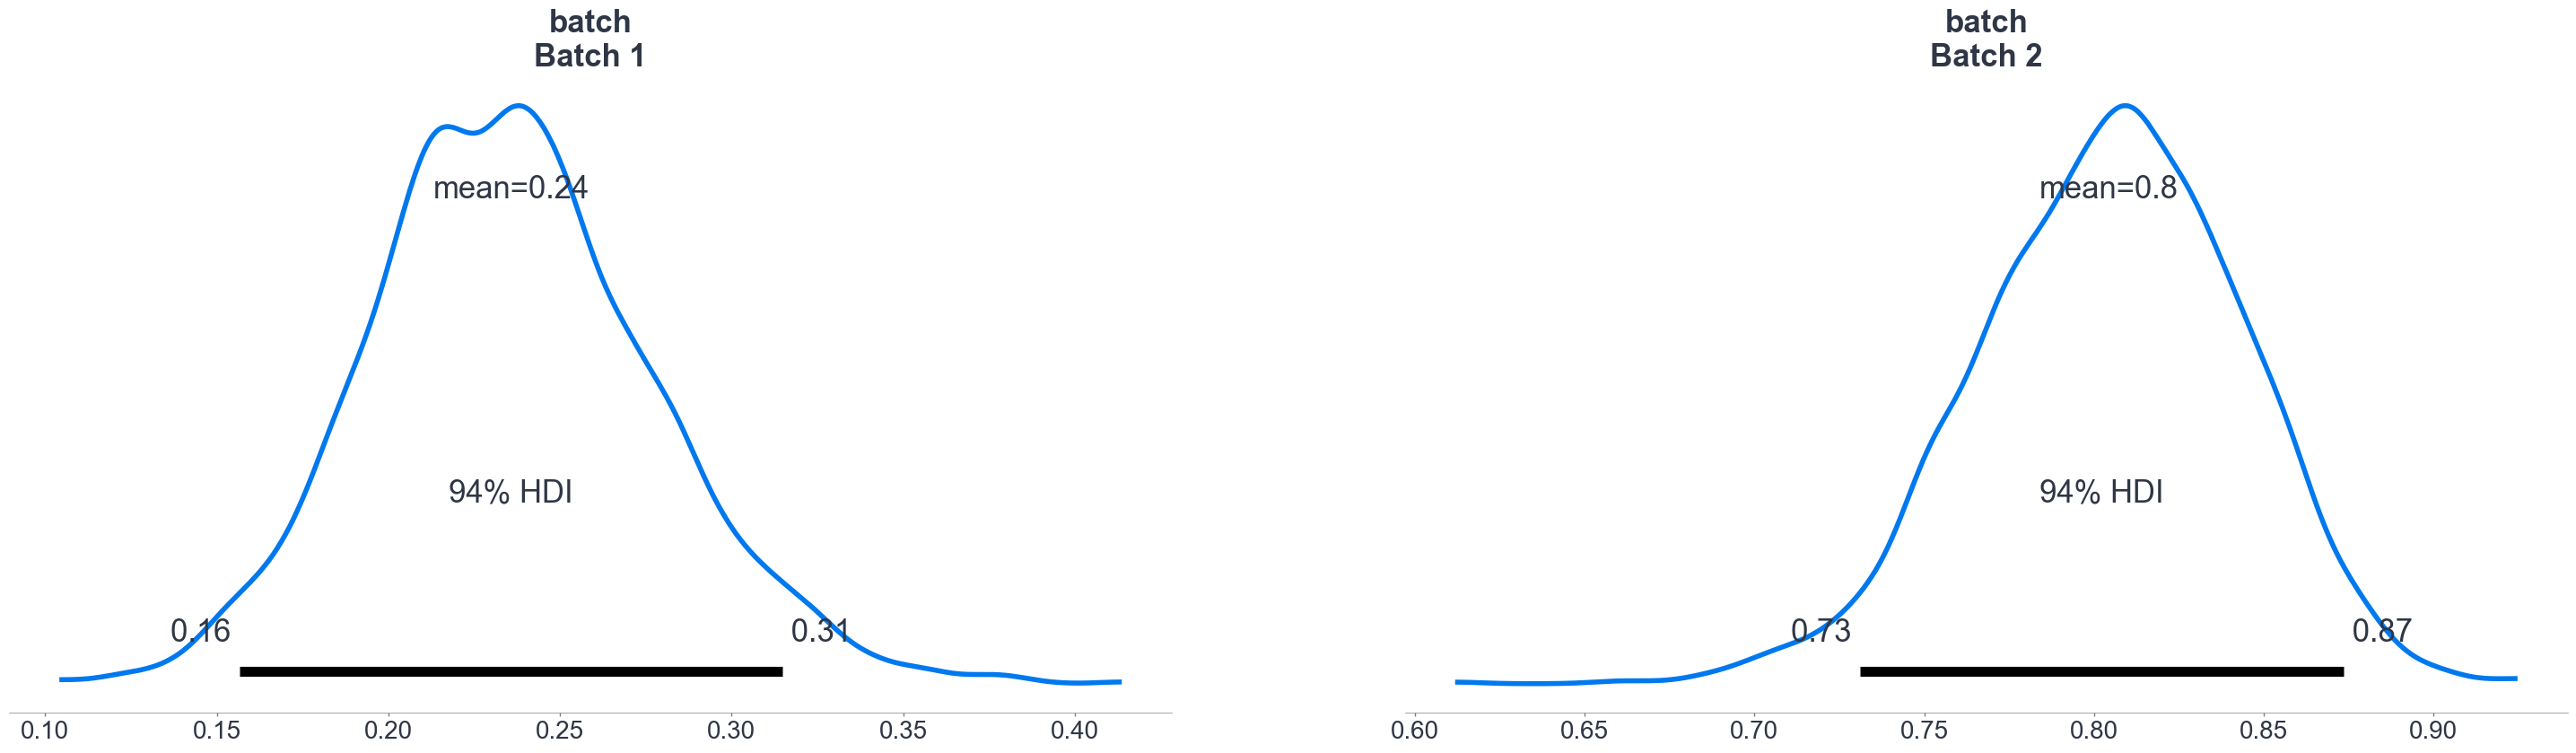

In [11]:
az.plot_posterior(idata_bambi);

Cool! Looks like the inferences we got with the Bambi model are close to the ones from hand-coded PyMC model. 

If we really want to compare them side by side we need to vsualize the success probability inferred by both models in the same chart. Let's do it!

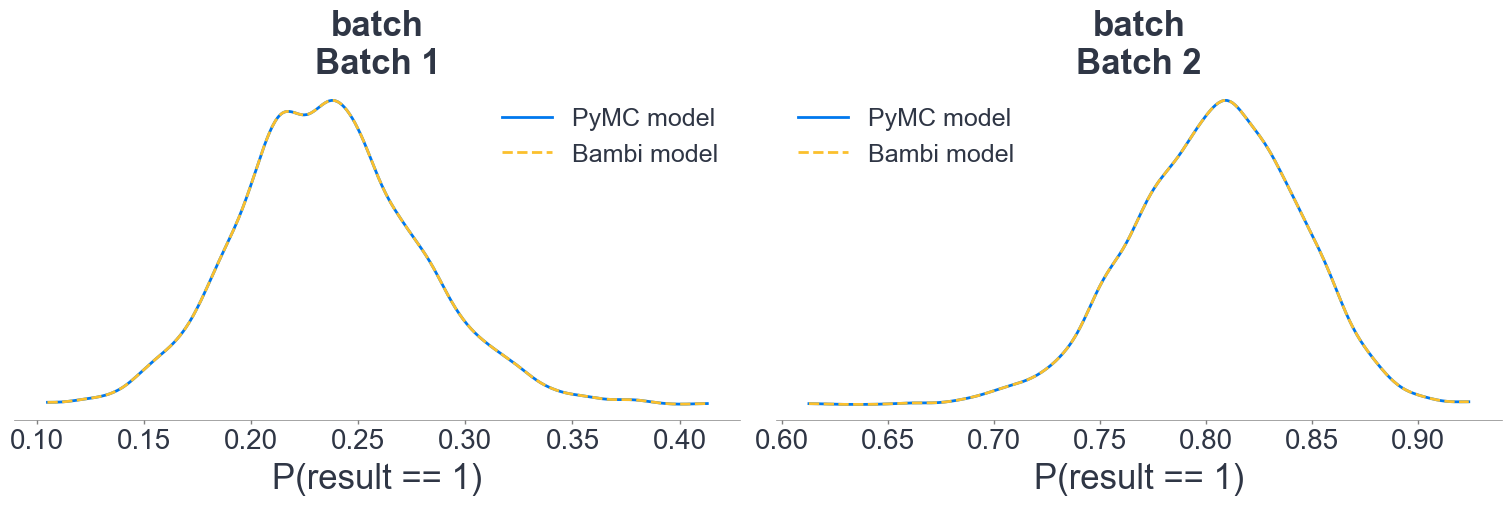

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), layout="constrained")
axes = az.plot_posterior(
    idata.posterior["estimated_probability"],
    hdi_prob="hide",
    point_estimate=None,
    lw=2,
    label="PyMC model",
    ax=axes
)
az.plot_posterior(
    idata_bambi.posterior["batch"],
    hdi_prob="hide", 
    point_estimate=None,
    color="C1",
    lw=2,
    ls="--",
    label="Bambi model",
    ax=axes, 
)
axes[0].set(xlabel="P(result == 1)")
axes[1].set(xlabel="P(result == 1)");

Wow! They're not close. They match perfectly! In other words, both the PyMC model and the Bambi model are in perfect agreement when it comes to inferring the probability of success for the different batches. 

For the nerds: Why do posteriors overlap perfectly? Isn't there a random component in how MCMC works? Were we so lucky? What can you make so the overlap is not that perfect (which may raise suspicious questions)?

#### Rethinking our choices

Think about the model you just coded.

1. Why did we use a Beta prior? 
2. How did it restrict the value of probability in a manner that we want per the definition of probability?
3. Now criticize the Beta prior we used.
    * Do you see any problem? Why?
    * Would you change something?
    * Share your answers in the discourse as well 😄

Write your answer below.

**Answer:** The Beta prior restricts possible values of probability to be between 0 and 1

### Part 2: Logistic regression model

Now let's recover our parameters using our new tool, the generalized linear model and non-identiy link functions.

**Hint:** You'll need to use some transform that converts any values into the probability scale.

Once you've recovered the parameters answer these questions
1. What is the domain of our priors? Is is retricted to the range of probability, that is between 0 and 1?
2. What is the logistic function doing for us? How does it affect the possible output range?

#### The logistic regression model with PyMC

In [13]:
batch, batch_idx = np.unique(df_samples["batch"], return_inverse=True)
coords = {"batch": batch}

with pm.Model(coords=coords) as ab_test_lin_reg:
    β = pm.Normal("β", 0, 1, dims="batch")
    p = pm.Deterministic("p", pm.math.sigmoid(β))
    obs = pm.Bernoulli("result", p=p[batch_idx], observed=df_samples["result"])
    idata_logistic = pm.sample(random_seed=1234)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [14]:
idata_logistic.posterior

<xarray.Dataset>
Dimensions:  (chain: 4, draw: 1000, batch: 2, p_dim_0: 2)
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999
  * batch    (batch) <U7 'Batch 1' 'Batch 2'
  * p_dim_0  (p_dim_0) int64 0 1
Data variables:
    β        (chain, draw, batch) float64 -1.058 1.789 -1.048 ... -1.407 1.58
    p        (chain, draw, p_dim_0) float64 0.2577 0.8568 ... 0.1967 0.8292
Attributes:
    created_at:                 2023-03-03T02:49:54.414309
    arviz_version:              0.14.0
    inference_library:          pymc
    inference_library_version:  5.0.1
    sampling_time:              1.7283265590667725
    tuning_steps:               1000

In [15]:
az.summary(idata_logistic, var_names=["β"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
β[Batch 1],-1.159,0.231,-1.619,-0.752,0.004,0.003,3691.0,2949.0,1.0
β[Batch 2],1.379,0.240,0.933,1.830,0.004,0.003,4155.0,3051.0,1.0


In [16]:
az.summary(special.expit(idata_logistic.posterior["β"]))["mean"]

β[Batch 1]    0.241
β[Batch 2]    0.796
Name: mean, dtype: float64

#### The logistic regression model with Bambi

Use Bambi to estimate the latent probability of each batch. We've provided some string encoding to help make your usage of Bambi even easier.

In [17]:
model = bmb.Model("result ~ 0 + batch", df_samples, family="bernoulli", link="logit")
model

Formula: result ~ 0 + batch
Family name: Bernoulli
Link: logit
Observations: 200
Priors:
  Common-level effects
    batch ~ Normal(mu: [0. 0.], sigma: [5. 5.])

In [18]:
idata_bambi = model.fit(draws=2000, chains=4, target_accept=0.85, random_seed=1234)

Modeling the probability that result==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [batch]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 3 seconds.


In [19]:
az.summary(idata_bambi)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
batch[Batch 1],-1.222,0.237,-1.650,-0.757,0.003,0.002,8466.0,5731.0,1.0
batch[Batch 2],1.470,0.257,0.987,1.951,0.003,0.002,8727.0,5410.0,1.0


In [20]:
az.summary(special.expit(idata_bambi.posterior["batch"]))["mean"]

batch[Batch 1]    0.23
batch[Batch 2]    0.81
Name: mean, dtype: float64

The possible range of our priors is negative inifinity to infinity. The logistic function restricts that range to (0,1) allowing us to estimate a probabiilty value that we can plug into a Bernoulli or Binomial likelihood. In this way the logistic function serves a similar purpose as our Beta prior, however it gives us the additional flexibility of being to use a more complex model that can include additional factors.

## Exercise 3: Predicting Penguins
The Palmer Penguin dataset is beoming increasingly popular in the data community. We'll be using it for our next exercise.

In particular we want to see if we can classify Adelie Penguins from Chinstrap penguns using their physical features. In this case we'll be using their bill length ot predict the species.

## Data Loading
We've provided the code to load the data below. We're be using two columns.

* `bill_length_mm`: Bill length in millimeters
* `species`: A categorical column that indicates which species the observation is for

For reference the Palmer penguins dataset includes as number of numerical attributes of the penguin. A [full description](https://allisonhorst.github.io/palmerpenguins/) is available on the github page.

Let's now see if we can Bambi to predict which penguin is which based off of its `bill_length`.

In [21]:
penguins = pd.read_csv("data/penguins.csv")
missing_data = penguins.isnull()[
    ["bill_length_mm"]
].any(axis=1)

# Drop rows with any missing data
penguins = penguins.loc[~missing_data]

species_filter = penguins["species"].isin(["Adelie", "Chinstrap"])
penguins_filtered = penguins[species_filter]

penguins_observed = penguins_filtered.iloc[:-5, :]

In [22]:
penguins_observed.head()

,rowid,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,1,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,2,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,3,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
4,5,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007
5,6,Adelie,Torgersen,39.3,20.6,190.0,3650.0,male,2007


### Part 1: Exploratory Data Analysis
Plot the species as a function of bill length. As statisticians we always want to do this to ensure we fully understand the data we are working with, verifying if it looks as expected, if there are any characteristics we weren't expecting, and ultimaetly to inform our modeling strategy,

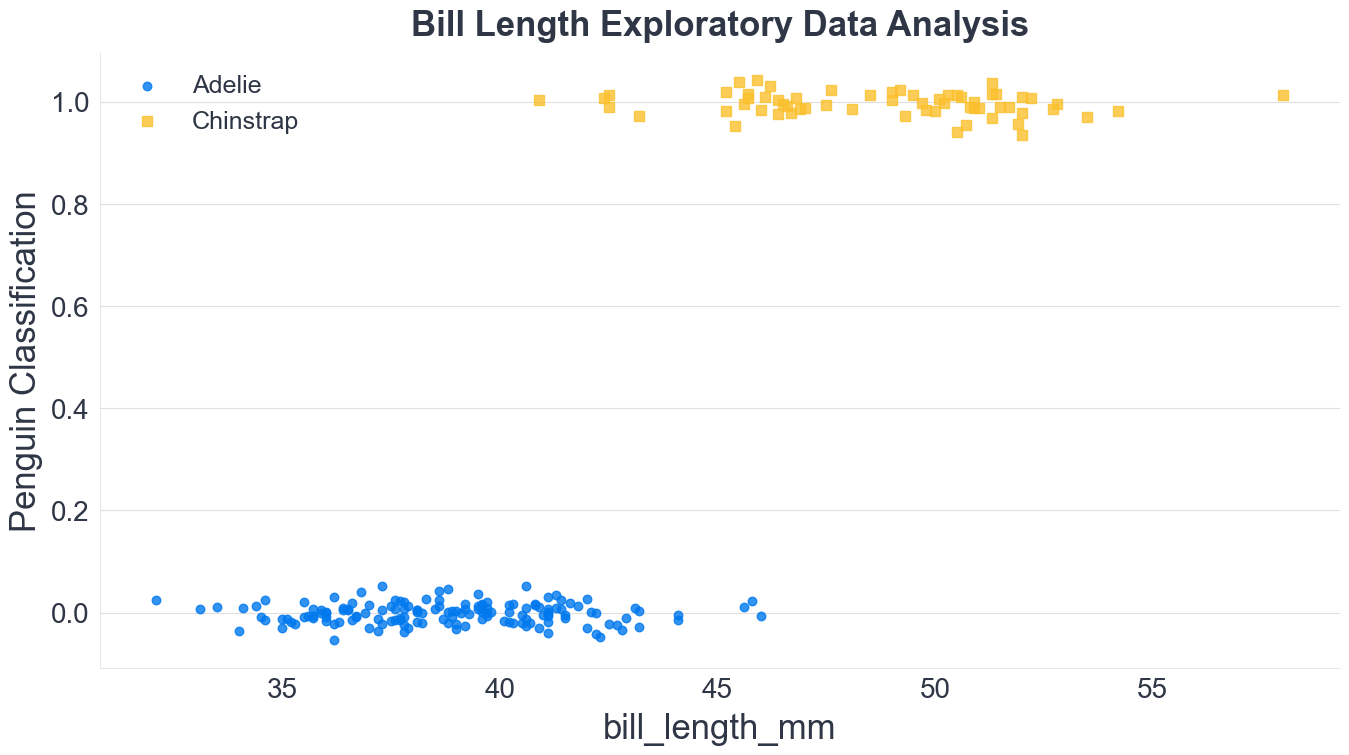

In [23]:
species = pd.Categorical(penguins_observed["species"])
fig, ax = plt.subplots()

def plot_species_observed(ax):
    for i, (label, marker) in enumerate(zip(species.categories, (".", "s"))):
        _filter = (species.codes == i)
        x = penguins_observed["bill_length_mm"][ _filter]
        y = np.random.normal(i, 0.02, size=_filter.sum())
        ax.scatter(x, y, marker=marker, label=label, alpha=.8, s=150*(1+i*-.6))
        ax.legend()
    return ax

ax.set_xlabel("bill_length_mm")
ax.set_ylabel("Penguin Classification")
ax.set_title("Bill Length Exploratory Data Analysis")

plot_species_observed(ax);

From the plot we can get a rough sense that there is a general difference between the Adelie penguins and Chinstrap penguins when it comes to bill length. There is a perfect separation but its quite evident the two species have different distributions of bill length.

### Part 1: Fitting the Bambi Logistic Regression Model
Fit a a Bambi model that uses logistic regression to predict which penguin is which. **Hint**. To make this a GLM you'll need to use the family and/or link argument in the model call.

In [24]:
# In this answer Chinstrip as the penguin that is encoded 1 to match the plot above

model = bmb.Model("species[Chinstrap] ~ bill_length_mm", penguins_observed, family="bernoulli", link="logit")
idata = model.fit(draws=2000, chains=4, target_accept=0.85, random_seed=1234)
az.summary(idata)

Modeling the probability that species==Chinstrap
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, bill_length_mm]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 3 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-43.303,6.478,-55.838,-31.737,0.125,0.090,2812.0,3444.0,1.0
bill_length_mm,0.979,0.148,0.709,1.260,0.003,0.002,2900.0,3518.0,1.0


Looking at these results we can tell there is some relationship between bill length and species. The mean, sd and HDI values of `bill_length_mm` are well above 0.

#### Part 2: Plotting the 
Use `bmb_plots` to overlay your previous EDA plot with the resullts from the logistic regression model. Take note of the HDI, where are we relatively certain of the penguin class, where are we less certain?

The plot overall looks as we'd expect. The uncertainty lies primarily around bill length 40 to 50mm. Below or above that we are fairly certain the penguin is either Adelie or Chinstrap respectively.

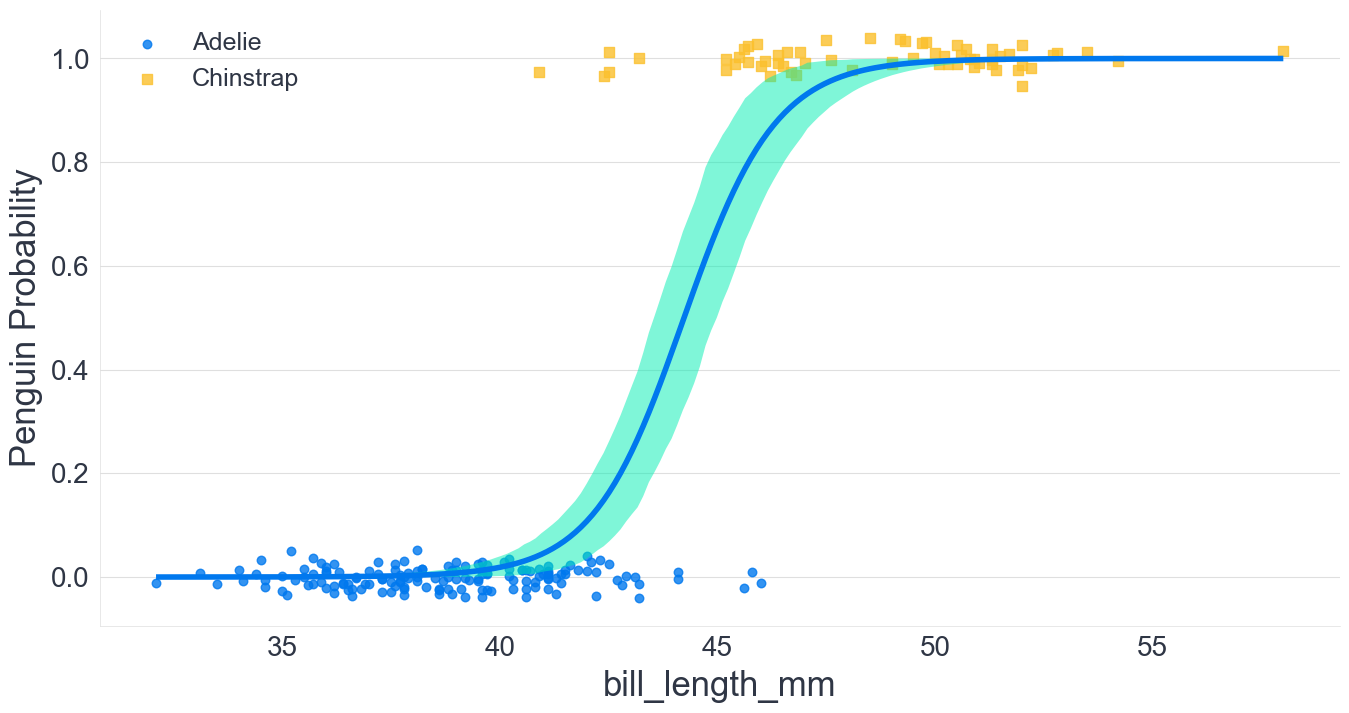

In [25]:
fig, ax = plt.subplots(figsize=(16, 8))
ax = plot_species_observed(ax)
bmb_plots.plot_cap(model, idata, ["bill_length_mm"], ax=ax)
ax.set(xlabel="bill_length_mm", ylabel="Penguin Probability", );

### Part 2: Penguin Predictions
What if we now discover additional penguins with bill lengths of 30, 40, 50 respectively? What would we predict their species to be?

Using the logistic regression model we fit above, determine what the probability of each penguin will be.

**Hint** You will need to do some Inference data manipulation to get the final prediction values. This is due to the way Markov Chain Monte Carlo works. We've provided the code belopw to help.

`{az.InferenceData].posterior.species_mean.mean(dim=("chain","draw"))`

In [26]:
bill_lengths = [30, 40, 50]
new_obs = pd.DataFrame({"bill_length_mm":bill_lengths})

In [27]:
predictions = model.predict(idata, data=new_obs, inplace=False)
predictions

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [28]:
prediction_means = predictions.posterior.species_mean.mean(dim=("chain","draw"))
prediction_means

<xarray.DataArray 'species_mean' (species_obs: 3)>
array([4.61556491e-06, 1.88048674e-02, 9.94512205e-01])
Coordinates:
  * species_obs  (species_obs) int64 0 1 2

In [29]:
# Print as percentages in a nice string

for flipper_length, num in zip([30, 40, 50], prediction_means.values):
    print(f"The probabiilty of a penguin with flipper length {flipper_length} is {num*100:.2f}%")

The probabiilty of a penguin with flipper length 30 is 0.00%
The probabiilty of a penguin with flipper length 40 is 1.88%
The probabiilty of a penguin with flipper length 50 is 99.45%


### Bonus: Plot the predictions

We can add the prediction to the plot.

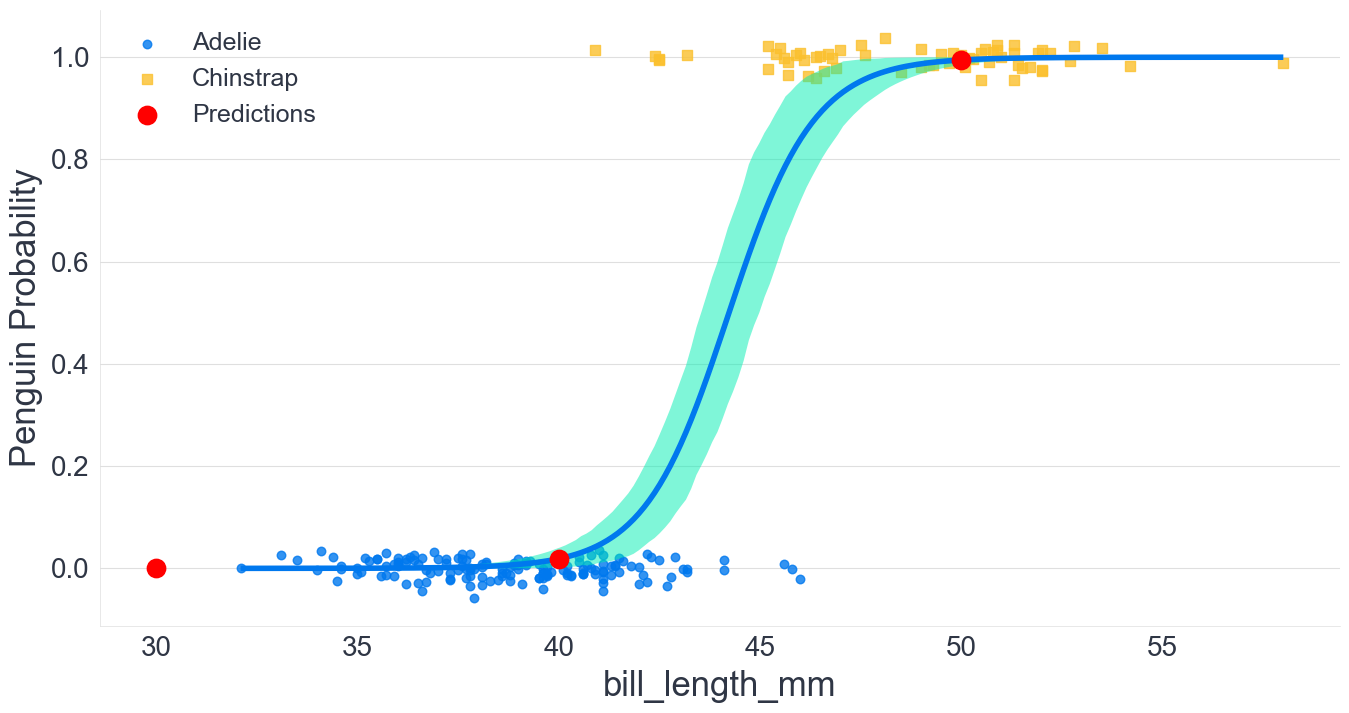

In [30]:
fig, ax = plt.subplots(figsize=(16, 8))
ax = plot_species_observed(ax)
bmb_plots.plot_cap(model, idata, ["bill_length_mm"], ax=ax)
ax.scatter(bill_lengths, prediction_means, c="red", s=700, zorder=20, label="Predictions")
ax.set(xlabel="bill_length_mm", ylabel="Penguin Probability", )
ax.legend();

# Exercise 4: Will this mushroom kill you?

Mushrooms are delicious, except when they're poisonous and kill you. We'll be using the mushroom dataset provided by the [UCI machine learning repository](https://archive-beta.ics.uci.edu/dataset/73/mushroom). Our goal in short is to predict


We want to understand which qualities predict mushroom toxicity. Bambi makes exploratory model building such as this quick, with fast model definitions and quick feedback loops. 

The full definition of the dataset can be found in the file [agaricus-lepiota.names](data/agaricus-lepiota.names). We've pulled the attribute names section from the data file.

```
7. Attribute Information: (classes: edible=e, poisonous=p)
     1. cap-shape:                bell=b,conical=c,convex=x,flat=f,
                                  knobbed=k,sunken=s
     2. cap-surface:              fibrous=f,grooves=g,scaly=y,smooth=s
     3. cap-color:                brown=n,buff=b,cinnamon=c,gray=g,green=r,
                                  pink=p,purple=u,red=e,white=w,yellow=y
     4. bruises?:                 bruises=t,no=f
     5. odor:                     almond=a,anise=l,creosote=c,fishy=y,foul=f,
                                  musty=m,none=n,pungent=p,spicy=s
     6. gill-attachment:          attached=a,descending=d,free=f,notched=n
     7. gill-spacing:             close=c,crowded=w,distant=d
     8. gill-size:                broad=b,narrow=n
     9. gill-color:               black=k,brown=n,buff=b,chocolate=h,gray=g,
                                  green=r,orange=o,pink=p,purple=u,red=e,
                                  white=w,yellow=y
    10. stalk-shape:              enlarging=e,tapering=t
    11. stalk-root:               bulbous=b,club=c,cup=u,equal=e,
                                  rhizomorphs=z,rooted=r,missing=?
    12. stalk-surface-above-ring: fibrous=f,scaly=y,silky=k,smooth=s
    13. stalk-surface-below-ring: fibrous=f,scaly=y,silky=k,smooth=s
    14. stalk-color-above-ring:   brown=n,buff=b,cinnamon=c,gray=g,orange=o,
                                  pink=p,red=e,white=w,yellow=y
    15. stalk-color-below-ring:   brown=n,buff=b,cinnamon=c,gray=g,orange=o,
                                  pink=p,red=e,white=w,yellow=y
    16. veil-type:                partial=p,universal=u
    17. veil-color:               brown=n,orange=o,white=w,yellow=y
    18. ring-number:              none=n,one=o,two=t
    19. ring-type:                cobwebby=c,evanescent=e,flaring=f,large=l,
                                  none=n,pendant=p,sheathing=s,zone=z
    20. spore-print-color:        black=k,brown=n,buff=b,chocolate=h,green=r,
                                  orange=o,purple=u,white=w,yellow=y
    21. population:               abundant=a,clustered=c,numerous=n,
                                  scattered=s,several=v,solitary=y
    22. habitat:                  grasses=g,leaves=l,meadows=m,paths=p,
                                  urban=u,waste=w,woods=d
```

With these attributes see what you can find in the dataset.See what you can find.  Share your results on Discourse. This is an open ended question and no right or wrong answer.

## Data Loading

In [31]:
mushrooms = pd.read_csv("data/mushrooms.csv")
mushrooms.columns = mushrooms.columns.str.replace(pat="-", repl="_")

mushrooms.head()

,class,cap_shape,cap_surface,cap_color,bruises,odor,gill_attachment,gill_spacing,gill_size,gill_color,...,stalk_surface_below_ring,stalk_color_above_ring,stalk_color_below_ring,veil_type,veil_color,ring_number,ring_type,spore_print_color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


## Part 1: Exploratory Data Analysis

We first check the number of occurences of both types of mushrooms, poisonous and edible. In this dataset the number of rows looks relatively balanced.

In [32]:
mushrooms["class"].value_counts()

e    4208
p    3916
Name: class, dtype: int64

We can then plot each column and individuall category within the label to get a sense of there is any single attribute separability between each poisnosus and edible mushrooms.

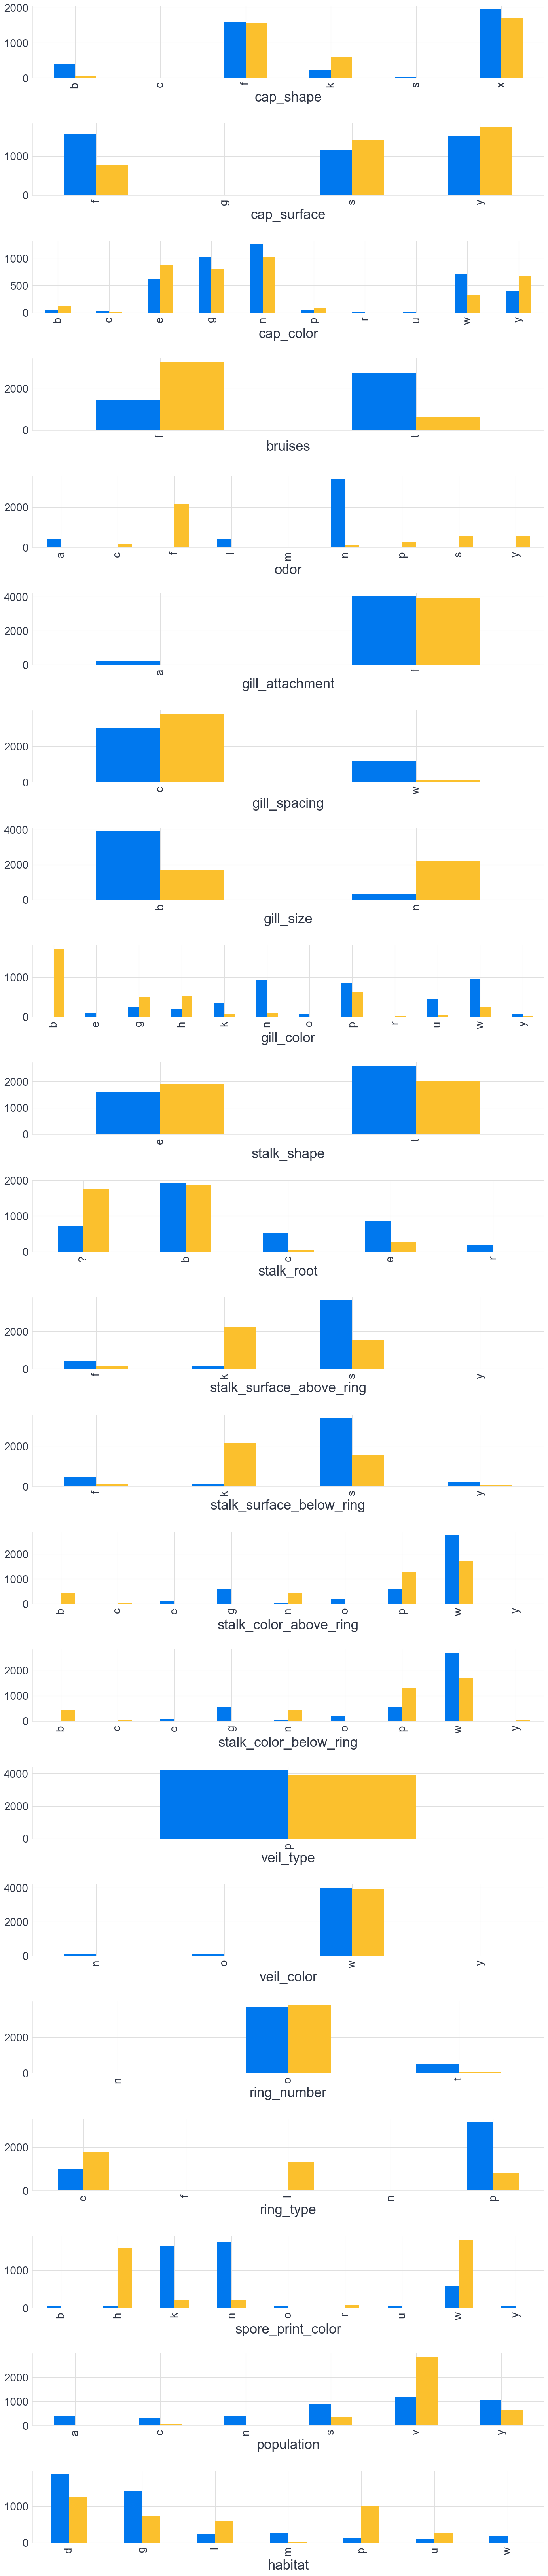

In [33]:
attributes = mushrooms.columns[1:]

fig, axes = plt.subplots(len(attributes), 1, figsize = (15, 3*len(attributes)))
fig.tight_layout(pad=2.0)

for ax, attr in zip(axes, attributes):
    _attr_sum = mushrooms[["class", attr]].groupby([attr, "class"]).size()
    _attr_sum.to_frame().reset_index().pivot(index=attr, columns="class").plot(kind="bar", ax=ax)
    ax.get_legend().remove()

## Part 2: Logistic Regression Modeling

Based off of EDA lets try modeling gill-size, ring-type, and odor. from that we can get a sense of which characteristics help us best estimate which mushroom is edible versus those that are not.

Before we run our sampler we'll recode the categorical indicators so its easier to understand their physical meaning in the subsequent plots.

In [34]:
mappings = dict(
  gill_size = dict(b='broad',n='narrow'),
  ring_type = dict(c='cobwebby',e='evanescent',f='flaring', l='large', n='none', p='pendant',s='sheathing', z='zone='),
  odor= dict(a='almond',l='anise',c='creosote',y='fishy',f='foul',m='musty',n='none',p='pungent',s='spicy'))

In [35]:
# Create new dataframe of columns

subset_df = pd.DataFrame(mushrooms["class"])

for column in ("gill_size", "ring_type", "odor"):
    subset_df[column] = mushrooms[column].replace(mappings[column])
    
subset_df.head()

,class,gill_size,ring_type,odor
0,p,narrow,pendant,pungent
1,e,broad,pendant,almond
2,e,broad,pendant,anise
3,p,narrow,pendant,pungent
4,e,broad,evanescent,none


In [36]:
model = bmb.Model("class[p] ~ gill_size + ring_type + odor", subset_df, family="bernoulli", link="logit")
idata = model.fit(draws=2000, chains=4, target_accept=0.85, random_seed=1234)

Modeling the probability that class==p
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, gill_size, ring_type, odor]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 346 seconds.


We can summarize with a table from ArviZ as we've done before to see which coefficients are larger than zero.

In [37]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-7.495,1.134,-9.563,-5.483,0.020,0.014,3844.0,3509.0,1.0
gill_size[narrow],2.709,0.206,2.307,3.084,0.003,0.002,5054.0,4586.0,1.0
ring_type[flaring],-27.643,18.748,-61.836,-2.108,0.382,0.280,2868.0,3097.0,1.0
ring_type[large],4.891,4.336,-2.736,13.322,0.089,0.065,2510.0,2985.0,1.0
ring_type[none],25.873,30.420,-29.760,83.424,0.587,0.453,2741.0,3035.0,1.0
ring_type[pendant],0.110,0.211,-0.266,0.527,0.003,0.002,5379.0,4735.0,1.0
odor[anise],-9.408,7.006,-22.651,1.263,0.128,0.096,3492.0,3324.0,1.0
odor[creosote],20.080,8.138,8.766,35.770,0.158,0.118,3321.0,3088.0,1.0
odor[fishy],16.107,4.356,9.427,24.256,0.104,0.083,2341.0,1884.0,1.0
odor[foul],15.463,2.285,11.590,19.805,0.046,0.033,2657.0,2898.0,1.0


Tables can be challenging to understand at a glance. We can also create a ridge plot to get a sense of the range and distribution of the posterior plot. Let's also add a vertical dashed line at 0 to make it easier to see what provides

Looks like certain odors are giveaways of toxicity in mushrooms.

array([<AxesSubplot:>], dtype=object)

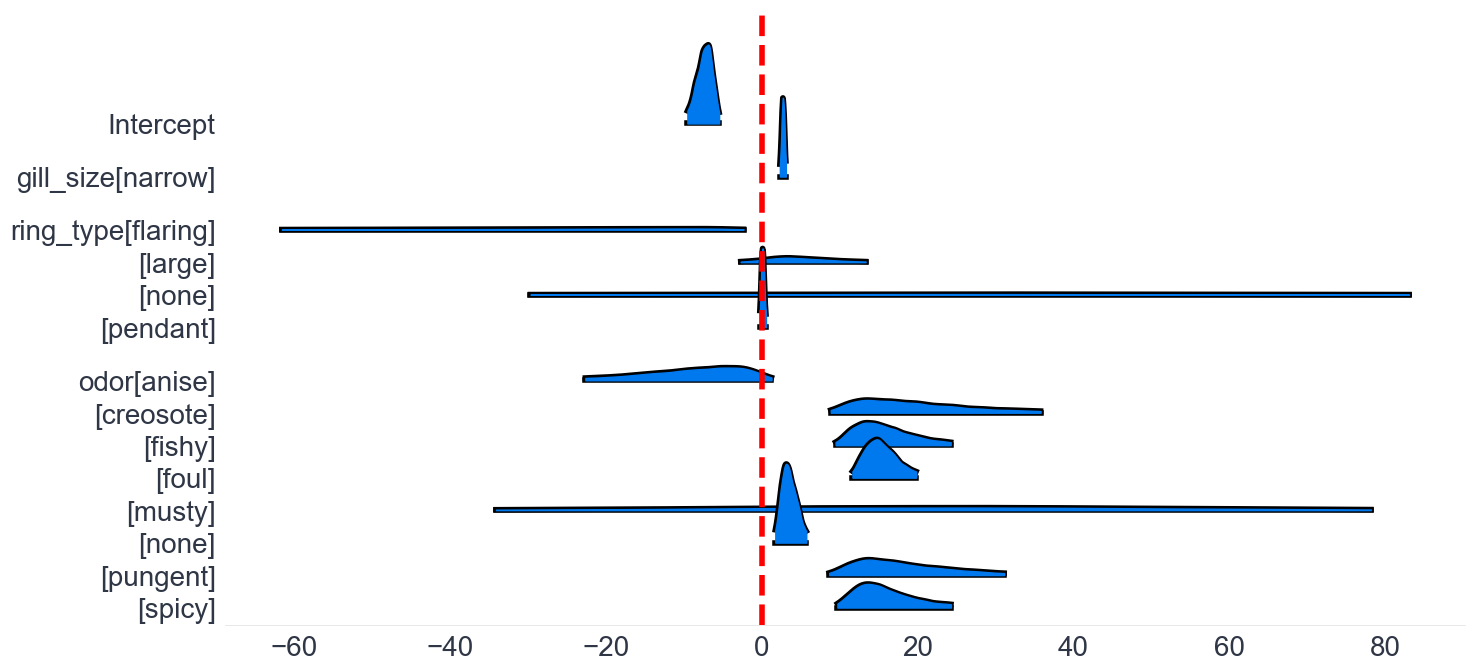

In [38]:
fig, ax = plt.subplots()

ax.axvline(0, c='r', linestyle="--")
az.plot_forest(idata, combined=True, kind="ridgeplot", ax=ax)

Let's focus in on one factor which is odor. If we take a look at the categories we can get a sense of which factors estimate the edibility of mushrooms. In the specific subcategories if you smell fishiness, foulness, pungeny or spiciness, theres an inreased change that mushroom is not edible. If it smells musty however its uncertain whether that makes it more or less likely to be edible

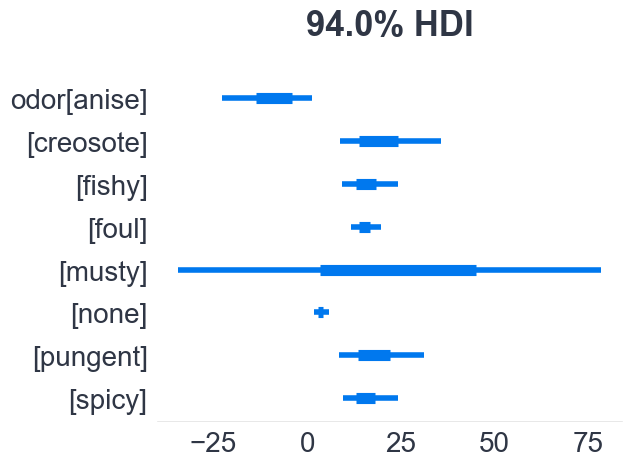

In [39]:
az.plot_forest(idata, var_names="odor", combined=True);

## Exercise 5: Complete separability

Let's now try something else with our mushroom dataset. Imagine a case where we pick with a certain gill attachment, but we observe they're all poisonous. This is a complete class separation.

In exercise you will be comparing maximum likelihood estimators with Bayesian estimators in a specific scenario, where one covariate has not observed both classes.



### Data Set Construction
Let's create that dataset ourselves. We're doing so, so we can focus on the mathematical idea here rather than a new dataset.

In [40]:
# All rows where gill attachment is a and the mushrooms are poisonous
poisonous_a_index =  mushrooms.query("gill_attachment == 'a' and `class` == 'p'").index
subset_mushrooms = mushrooms[~mushrooms.index.isin(poisonous_a_index)][["gill_attachment", "ring_number", "class"]]

Great now we have data set where every mushroom of gill_attachment `a` is poisonous. 

### EDA 

Now because we constructed this dataset the results of this EDA are not surprising to us. However because we're good statisticians we always want to make sure we don't skip this important step. 

In [41]:
# Verify that gill_attachemnt a only has edible mushrooms
subset_mushrooms.groupby(["gill_attachment", "ring_number", "class"]).size()

gill_attachment  ring_number  class
a                o            e         192
f                n            p          18
                 o            e        3488
                              p        3808
                 t            e         528
                              p          72
dtype: int64

### Maximum Likelihood Estimation
Here we've setup the statsmodels regression for you. Run the model and see what the results are.

In [42]:
# Statsmodel requires the output column to be binary so we need to do this conversion ourselves
# Bambi handles this for us automatically!
subset_mushrooms["class_int"] = subset_mushrooms["class"].replace({"e":0, "p":1})

In [43]:
import statsmodels.formula.api as smf

log_reg = smf.logit("class_int ~ ring_number + gill_attachment", data=subset_mushrooms).fit()

         Current function value: 0.650177
         Iterations: 35


/home/canyon/miniconda3/envs/ib_advanced_regression/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Statsmodels is unable to fit this regression stating a failure to converge. Aside from warning we can see the same in the summary table, the intercept and gill attachment have a massive standard error, indicating the model failed to fit.

In [44]:
log_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              class_int   No. Observations:                 8106
Model:                          Logit   Df Residuals:                     8102
Method:                           MLE   Df Model:                            3
Date:                Thu, 02 Mar 2023   Pseudo R-squ.:                 0.06100
Time:                        18:56:09   Log-Likelihood:                -5270.3
converged:                      False   LL-Null:                       -5612.7
Covariance Type:            nonrobust   LLR p-value:                4.212e-148
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -3.7685   1.49e+04     -0.000      1.000   -2.92e+04    2.92e+04
ring_number[T.o]       -20.4709   6864.766     -0.003      0.998   -1.35e+04    1.34e+04
ring_number[T.t]       -22.5511   6864.766     -0.003      0.997   -1.35e+04    1.34e+04
gill_attachment[T.f]    24.3272   1.32e+04      0.002      0.999   -2.59e+04     2.6e+04
========================================================================================
"""

### Why does the model fail?

Maximum likelihood estimators, well, maximizes the likelihood that the observed data is what will be produced by the estimated parameters. This may seem obvious from the description, and desirable as a practitioner. However in situations like these it can lead to odd results.

If the model is seeing all mushrooms are "edible" for a certain gill attachment, then the maximum likelihood of a poisonous mushroom with that gill attachment is zero. This is equivalent to the probability of "p" equal to "zero", However with logistic regression model this is not possible because a sigmoid function has to range from 0 to 1 without including the borders. This means the estimator "pushes" the coefficients to infinity and that just isn't a useful result.

## Bayesian Regression
Now lets try Bayesian regression. Before fitting the model think through one question. In Bayesian models what's one extra piece of information that is not used in frequentist or maximum likelihood methods?

In [45]:
model = bmb.Model("class[p] ~ gill_attachment + ring_number", subset_mushrooms, family="bernoulli", link="logit")
idata = model.fit(draws=2000, chains=4, target_accept=0.85, random_seed=1234)

Modeling the probability that class==p
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, gill_attachment, ring_number]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 297 seconds.


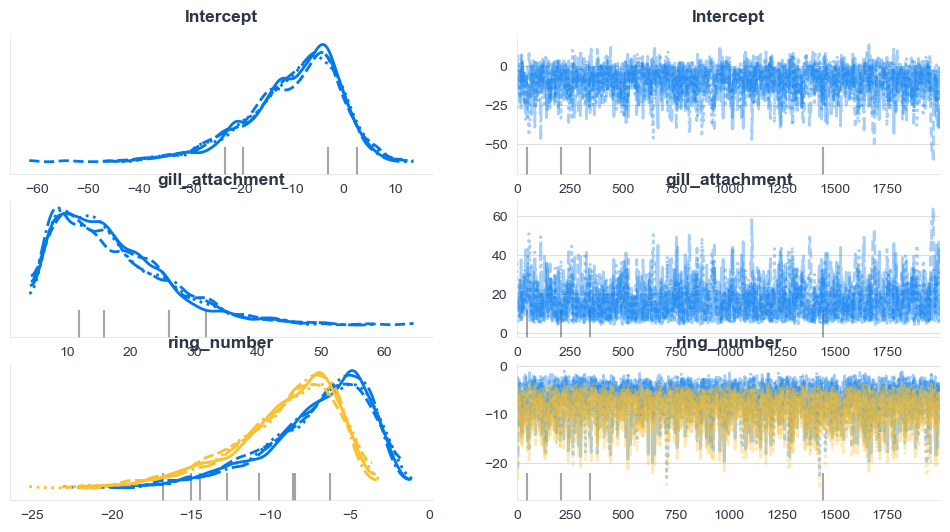

In [46]:
az.plot_trace(idata);

In [47]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-9.971,9.256,-27.698,5.682,0.298,0.217,1042.0,1353.0,1.0
gill_attachment[f],17.125,8.776,4.868,33.202,0.293,0.211,1012.0,1287.0,1.0
ring_number[o],-7.067,3.360,-13.440,-1.872,0.104,0.074,1151.0,1581.0,1.0
ring_number[t],-9.152,3.359,-15.551,-3.981,0.104,0.074,1151.0,1579.0,1.0


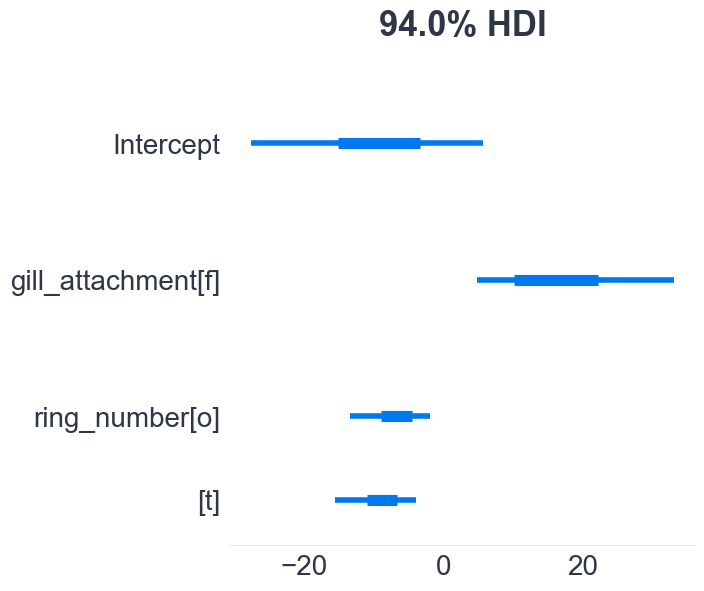

In [48]:
az.plot_forest(idata, combined=True);